In [1]:
# Imports
import sys
sys.path.insert(1, '../')
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import uproot
import pickle
import analysis.vector as vector
import analysis.Master as Master
import time

In [2]:
# Functions
def del_prop(obj, property_name):
    del(obj.__dict__["_RecoPairData__" + property_name])
    return

def get_beam_impact_point(direction, start_pos, beam_vertex):
    rel_pos = vector.sub(beam_vertex, start_pos)
    cross = vector.cross(rel_pos, direction)
    return vector.magnitude(cross)

In [3]:
# Edit the base classes to fit what we want to be doing with pairs
class RecoPairData(Master.RecoParticleData):
    @property
    def pandoraTag(self):
        self.LoadData("pandoraTag", "pandoraTag")
        return getattr(self, f"_{type(self).__name__}__pandoraTag")

    @property
    def cnnScore(self):
        self.LoadData("cnnScore", "CNNScore_collection")
        return getattr(self, f"_{type(self).__name__}__cnnScore")

class PairData(Master.Data):
    def __init__(self, _filename : str = None, includeBackTrackedMC : bool = False, _nEvents : int = -1, _start : int = 0) -> None:
        super().__init__(_filename, includeBackTrackedMC, _nEvents, _start)
        if self.filename != None:
            self.recoParticles = RecoPairData(self)
    
    def ApplyBeamTypeFilter(self, beam_pdg):
        """ Applies a beam filter to the sample, which selects events
            which have a beam particle with the supplied pdg code.
        """
        if self.recoParticles.beam_number is None:
            print("data doesn't contain beam number, can't apply filter.")
            return
        hasBeam = self.recoParticles.beam_number != -999 # check if event has a beam particle
        hasBeam = np.logical_and(self.recoParticles.beamVertex.x != -999, hasBeam)

        beamParticle = self.recoParticles.number == self.recoParticles.beam_number # get beam particle
        del_prop(self.recoParticles, "number")
        self.beamParticleDaughters = self.recoParticles.mother == self.recoParticles.beam_number # get daugter of beam particle
        del_prop(self.recoParticles, "beam_number")
        del_prop(self.recoParticles, "mother")
        
        beam_type_mask = ak.all(self.trueParticlesBT.pdg[beamParticle] == beam_pdg, -1)
        # combine masks
        # particle_mask = np.logical_or(beamParticle, beamParticleDaughters)
        #? which one to do?
        self.Filter([hasBeam, beam_type_mask[hasBeam]], [hasBeam, beam_type_mask[hasBeam]]) # filter data
        # self.Filter([hasBeam, particle_mask[hasBeam]], [hasBeam]) # filter data
    
    @property
    def NonBeamPi0Number(self):
        return self.number[self.pdg == 111]

In [4]:
# Load the events (ETA ~1min for a single 6GeV beam v2 sample). ETA ~10s
events = PairData("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

In [5]:
# Apply cuts:
n = [["event selection", "number of PFOs", "number of events", "percentage of events removed"]]
n.append(["no selection", ak.count(events.trueParticlesBT.pdg), ak.count(events.eventNum), "-"])

# Require a beam particle to exist. ETA ~60s:
ts = time.time()
events.ApplyBeamTypeFilter(211)
print(f"pi+ beam done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Require a beam particle to exist. ETA ~120s:
# ts = time.time()
# events.ApplyBeamFilter()
# print(f"beam done in {time.time()  - ts}s")
# evt_remaining = ak.count(events.eventNum)
# n.append(["beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])
# ts = time.time()
# true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
# f = ak.all(true_beam == 211, -1)
# events.Filter([f], [f])
# del(true_beam)
# print(f"pi+ beam done in {time.time()  - ts}s")
# evt_remaining = ak.count(events.eventNum)
# n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Only look at PFOs with > 50 hits. ETA ~30s:
ts = time.time()
events.Filter([events.recoParticles.nHits > 50], [])
del_prop(events.recoParticles, "nHits")
print(f"Hits > 50 done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["nHits >= 51", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Require >= 2 PFOs. ETA ~240s=4mins:
ts = time.time()
f = Master.NPFPMask(events)
del_prop(events.recoParticles, "direction")
del_prop(events.recoParticles, "startPos")
events.Filter([f], [f])
print(f"PFOs >= 2 done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Take CNNScore > 0.36. ETA ~30s:
cnn_cut = 0.36
ts = time.time()
events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
del_prop(events.recoParticles, "cnnScore")
print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

print(n)

/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")


pi+ beam done in 67.49937725067139s


/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")


Hits > 50 done in 22.08060884475708s
PFOs >= 2 done in 250.33807182312012s
CNNScore > 0.36 done in 46.685996770858765s
[['event selection', 'number of PFOs', 'number of events', 'percentage of events removed'], ['no selection', 64987977, 100222, '-'], ['pi+ beam', 20717918, 34316, 65.76001277164694], ['nHits >= 51', 2029274, 34316, 0.0], ['nPFP >= 2', 2029274, 34316, 0.0], ['CNNScore > 0.36', 494700, 34316, 0.0]]


In [9]:
# Signal:
# # Get IDs of pions from beam
# beam_pi0 = np.logical_and(events.trueParticlesBT.pdg == 211, events.recoParticles.beamParticleDaughters)
# # Get IDs of photons from beam
# pi0_photons = np.logical_and(events.trueParticlesBT.pdg == 22, events.recoParticles.mother == events.recoParticles.number[beam_pi0])
# # Get shower with mother = id'ed photons

pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
f = events.trueParticlesBT.mother == pi0

# ETA ~xs:
true_photons = ak.flatten(events.trueParticles.number[events.trueParticles.truePhotonMask])
# pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
true_photon_mask = events.trueParticlesBT.number == true_photons

signal_impacts = get_beam_impact_point(events.recoParticles.direction[true_photon_mask], events.recoParticles.startPos[true_photon_mask], events.beamVertex)

# Bkg:
# Not beam
non_beam_filter = events.trueParticlesBT.number != events.recoParticles.beam_number
# and not true photon
bkg_pfos = np.logical_and(non_beam_filter, np.logical_not(true_photon_mask))
del(non_beam_filter)

bkg_impacts = get_beam_impact_point(events.recoParticles.direction[true_photons], events.recoParticles.startPos[true_photons], events.beamVertex)


ValueError: cannot broadcast RegularArray of size 33410 with RegularArray of size 41048

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/awkward/_util.py#L914)

In [15]:
# mother_ids = events.recoParticles.mother
# photons = events.trueParticlesBT.pdg == 22 # PFP is a photon
# pi0_ids = events.trueParticles.number[events.trueParticles.pdg == 111] # get all pi0s
# m = ak.Array([ ak.any( ak.unflatten(events.trueParticlesBT.mother[i], 1, -1) == pi0_ids[i], -1 ) for i in range(nEvents) ]) # ID of mother is in the pi^0 IDs

# mother_ids = events.trueParticlesBT.mother
# truth_ids = events.trueParticles.number
# truth_pdgs = events.trueParticles.pdg
mother_pdgs = mother_ids.to_list()
ts = time.time()
for i in range(100):#ak.count(events.eventNum)):
    print(mother_ids[i])
    print(truth_ids[i])
    print(truth_pdgs[i])
    print(mother_pdgs[i])
    print(len(truth_ids[i]))
    true_pdg_lookup = {truth_ids[i][d]:truth_pdgs[i][d] for d in range(ak.count(truth_ids[i]))}
    true_pdg_lookup.update({0:0, 1:0})
    print(true_pdg_lookup)
    mother_pdgs[i] = [true_pdg_lookup[mother_ids[i][j]] for j in range(ak.count(mother_ids[i]))]
    print(mother_pdgs[i])
print(f"100 events done in {time.time()  - ts}s")
mother_pdgs = ak.Array(mother_pdgs)
print(mother_pdgs)

[850877, 0, 0, 0, 0, 0, 0, 0, ... 836693, 836693, 836693, 0, 836693, 850874, 836688]
[547180, 547214, 547215, 836688, 845012, ... 853840, 853841, 850880, 852463, 852464]
[111, 22, 22, 111, 22, 22, 111, 22, 22, ... 111, 22, 22, 111, 22, 22, 111, 22, 22]
[850877, 0, 0, 0, 0, 0, 0, 0, 850874, 836695, 0, 850875, 850877, 836693, 0, 0, 0, 0, 836693, 836693, 836693, 0, 836693, 850874, 836688]
33
{547180: 111, 547214: 22, 547215: 22, 836688: 111, 845012: 22, 845013: 22, 836693: 111, 838496: 22, 838497: 22, 836695: 111, 837168: 22, 837169: 22, 846754: 111, 846909: 22, 846910: 22, 847915: 111, 847946: 22, 847947: 22, 850874: 111, 857145: 22, 857146: 22, 850875: 111, 856425: 22, 856426: 22, 850876: 111, 855643: 22, 855644: 22, 850877: 111, 853840: 22, 853841: 22, 850880: 111, 852463: 22, 852464: 22, 0: 0, 1: 0}
[111, 0, 0, 0, 0, 0, 0, 0, 111, 111, 0, 111, 111, 111, 0, 0, 0, 0, 111, 111, 111, 0, 111, 111, 111]
[622735, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 622735, 0, 0, 0, 0, 0, 0]
[53144, 53162, 53163, 9

KeyError: 753108

In [ ]:
del mother_ids
del truth_ids
del truth_pdgs

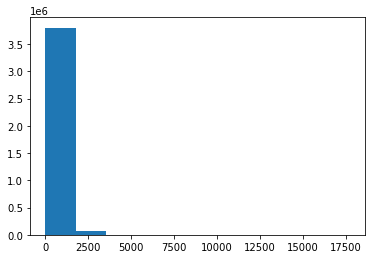

In [6]:
# Stupid simple thing:
# Need to find a way to confirm that combinations will always give the same combinations for the same shaped arrays:
#  Does an pair in paired_momenta match with a pair in pi0_photons_in_pair
paired_momenta = ak.combinations(events.recoParticles.momentum, 2)

def paired_mass(pairs):
    e = vector.magnitude(pairs["0"]) + vector.magnitude(pairs["1"])
    p = vector.magnitude(vector.add(pairs["0"], pairs["1"]))
    return np.sqrt(e**2 - p**2)

masses = ak.ravel(paired_mass(paired_momenta))

plt.hist(masses)

plt.show()

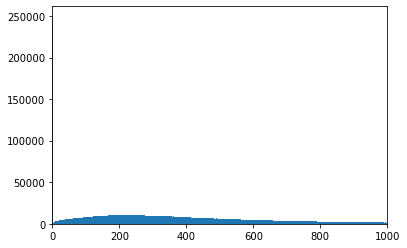

In [7]:
plt.hist(masses, bins=10000)
plt.xlim(0,1000)
plt.show()

In [42]:
print(n)

[['event selection', 'number of PFOs', 'number of events', 'percentage of events removed'], ['no selection', 64987977, 100222, '-'], ['pi+ beam', 20717918, 34316, 65.76001277164694], ['nHits >= 51', 2029274, 34316, 0.0], ['nPFP >= 2', 2029274, 34316, 0.0], ['CNNScore > 0.36', 494700, 34316, 0.0]]


In [46]:
print(n)

[['event selection', 'number of PFOs', 'number of events', 'percentage of events removed'], ['no selection', 64987977, 100222, '-'], ['pi+ beam', 20717918, 34316, 65.76001277164694], ['nHits >= 51', 2029274, 34316, 0.0], ['nPFP >= 2', 2029274, 34316, 0.0], ['CNNScore > 0.36', 494700, 34316, 0.0]]
